In [1]:
from __future__ import print_function
import math
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
from utils_BNN_resnet import neg_ELBO, Logger
from BayesianResnet import resnet18
import torchvision.models as models
from model_BNN_test import Small_conv_net
import torch.nn.functional as F
from model_SNN import Net
import matplotlib.pyplot as plt

# Setup

In [2]:
use_cuda = torch.cuda.is_available()

learning_rate = 0.001
weight_decay = 0
batch_size = 16
num_epochs = 7

In [3]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

In [4]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

Files already downloaded and verified
Files already downloaded and verified


# Frequentist Net

In [5]:
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)

criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
frequentist_train_acc = []
frequentist_val_acc = []

for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    m_train = math.ceil(len(train_data) / batch_size)
    m_test= math.ceil(len(test_data) / batch_size)

    total = 0
    correct = 0

    for batch_idx, (data, target) in zip(tqdm(range(m_train)),(train_loader)):
        model.train()
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item() * data.size(0))

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        model.eval()
        for i, (test_input, test_target) in zip(tqdm(range(m_test)), test_loader):
        # for (test_data, test_target) in test_loader:
            test_input, test_target = test_input.cuda(), test_target.cuda()
            test_outputs= model(test_input)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_target.size(0)
            test_correct += (test_predicted == test_target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)

    frequentist_train_acc.append(correct / total)
    frequentist_val_acc.append(test_correct/ test_total)
        
    print('--------------------------------------------------------------')
    print('Epoch:', epoch)
    print('--------------------------------------------------------------')
    print('Trainig loss:', train_loss)
    print('--------------------------------------------------------------')
    print('Accuracy of the network on the train images: {} percent ({}/{})'.format (
            100 * correct / total, correct, total))
    print('--------------------------------------------------------------')

    print('Accuracy of the network on the test images: {} percent ({}/{})'.format (
            100 * test_correct/ test_total, test_correct,test_total))
    print('--------------------------------------------------------------')


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 549.38it/s]


--------------------------------------------------------------
Epoch: 1
--------------------------------------------------------------
Trainig loss: 1.5094007669067382
--------------------------------------------------------------
Accuracy of the network on the train images: 46.004 percent (23002/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 45.28 percent (283/625)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 543.55it/s]


--------------------------------------------------------------
Epoch: 2
--------------------------------------------------------------
Trainig loss: 1.2709720345878601
--------------------------------------------------------------
Accuracy of the network on the train images: 54.872 percent (27436/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 51.2 percent (320/625)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 517.72it/s]


--------------------------------------------------------------
Epoch: 3
--------------------------------------------------------------
Trainig loss: 1.1757421857738495
--------------------------------------------------------------
Accuracy of the network on the train images: 58.438 percent (29219/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.32 percent (352/625)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 527.36it/s]


--------------------------------------------------------------
Epoch: 4
--------------------------------------------------------------
Trainig loss: 1.1102157763576508
--------------------------------------------------------------
Accuracy of the network on the train images: 60.906 percent (30453/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.48 percent (378/625)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 537.82it/s]


--------------------------------------------------------------
Epoch: 5
--------------------------------------------------------------
Trainig loss: 1.0577446926307679
--------------------------------------------------------------
Accuracy of the network on the train images: 62.814 percent (31407/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.72 percent (392/625)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 563.08it/s]


--------------------------------------------------------------
Epoch: 6
--------------------------------------------------------------
Trainig loss: 1.0121273076534272
--------------------------------------------------------------
Accuracy of the network on the train images: 64.448 percent (32224/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 63.2 percent (395/625)
--------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 625/625 [00:01<00:00, 497.87it/s]


--------------------------------------------------------------
Epoch: 7
--------------------------------------------------------------
Trainig loss: 0.9715715975666046
--------------------------------------------------------------
Accuracy of the network on the train images: 65.986 percent (32993/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 65.12 percent (407/625)
--------------------------------------------------------------


In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [9]:
def test( model, device, test_loader, epsilon ):
    model.eval()
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [10]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 6452 / 10000 = 0.6452
Epsilon: 0.05	Test Accuracy = 1781 / 10000 = 0.1781
Epsilon: 0.1	Test Accuracy = 372 / 10000 = 0.0372
Epsilon: 0.15	Test Accuracy = 96 / 10000 = 0.0096
Epsilon: 0.2	Test Accuracy = 30 / 10000 = 0.003
Epsilon: 0.25	Test Accuracy = 11 / 10000 = 0.0011
Epsilon: 0.3	Test Accuracy = 16 / 10000 = 0.0016


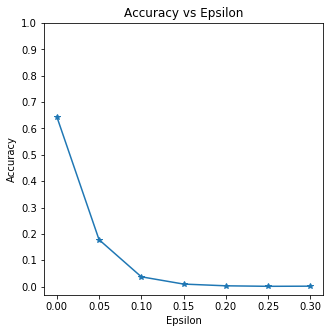

In [13]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()